In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
from matplotlib.colors import LogNorm
from matplotlib import cm
import matplotlib
from scipy import stats
import copy
from function import confid

import cartopy.crs as ccrs                   # import projections
import cartopy
import scipy.signal
from scipy.io import loadmat
import pyresample

/vortexfs1/home/wwu/.conda/envs/myenv/lib/python3.8/site-packages/pyresample/bilinear/__init__.py:50: UserWarning: XArray and/or zarr not found, XArrayBilinearResampler won't be available.
  warnings.warn("XArray and/or zarr not found, XArrayBilinearResampler won't be available.")


In [2]:
#loading global 5m 0.1 deg U,V and SSH fft data
#each file is half-globe

N=1022. # number of data points (use later to normalize fft output)
path='data/PoP_global/fft_5m_u_hann_26_39_1.nc'
#path='/vortexfs1/share/mahadevanlab/roger/PoP_global/fft_5m_u_hann_26_39_1.nc'
nc=Dataset(path,'r')
fft_u1 = nc.variables['fft_su_real'][:] \
       + 1j* nc.variables['fft_su_img'][:]
nc.close()
path='data/PoP_global/fft_5m_u_hann_26_39_2.nc'
#path='/vortexfs1/share/mahadevanlab/roger/PoP_global/fft_5m_u_hann_26_39_2.nc'
nc=Dataset(path,'r')
fft_u2 = nc.variables['fft_su_real'][:] \
       + 1j* nc.variables['fft_su_img'][:]
nc.close()
fft_u=np.ma.append(fft_u1,fft_u2,axis=2)

path='data/PoP_global/fft_5m_v_hann_26_39_1.nc'
#path='/vortexfs1/share/mahadevanlab/roger/PoP_global/fft_5m_v_hann_26_39_1.nc'
nc=Dataset(path,'r')
fft_v1 = nc.variables['fft_sv_real'][:] \
       + 1j* nc.variables['fft_sv_img'][:]
nc.close()

path='data/PoP_global/fft_5m_v_hann_26_39_2.nc'
#path='/vortexfs1/share/mahadevanlab/roger/PoP_global/fft_5m_v_hann_26_39_2.nc'
nc=Dataset(path,'r')
fft_v2 = nc.variables['fft_sv_real'][:] \
       + 1j* nc.variables['fft_sv_img'][:]
fft_v=np.ma.append(fft_v1,fft_v2,axis=2)
df=nc.variables['cycle_per_day'][1]- nc.variables['cycle_per_day'][0]
S_u = np.mean(2.* (np.absolute(fft_u)**2.)/(N**2. * df),axis = 0)
S_v = np.mean(2.* (np.absolute(fft_v)**2.)/(N**2. * df),axis = 0)
nc.close()

path='data/PoP_global/fft_ssh_hann_26_39_1.nc'
#path='/vortexfs1/share/mahadevanlab/roger/PoP_global/fft_ssh_hann_26_39_1.nc'
nc=Dataset(path,'r')
fft_h1 = nc.variables['fft_ssh_real'][:] \
       + 1j* nc.variables['fft_ssh_img'][:]
nc.close()
path='data/PoP_global/fft_ssh_hann_26_39_2.nc'
#path='/vortexfs1/share/mahadevanlab/roger/PoP_global/fft_ssh_hann_26_39_2.nc'
nc=Dataset(path,'r')
fft_h2 = nc.variables['fft_ssh_real'][:] \
       + 1j* nc.variables['fft_ssh_img'][:]
fft_h=np.ma.append(fft_h1,fft_h2,axis=2)
nc.close()



In [3]:
# the fft data above is not at uniform grid, we are loading the model 
#grid and resample them into 0.1 deg grid 
path='data/UV_angle.nc'
#path='/vortexfs1/home/wwu/Rossby_Wave_Project/data/UV_angle.nc'
nc=Dataset(path,'r')
lon=nc.variables['ULONG'][300:2000,:]
lat=nc.variables['ULAT'][300:2000,:]
lon =360*(lon<0)+lon

#the longitude of coherence reference location, default is 230.
#(the resolution of longitude and latitude is 0.1 deg)
ref_lon =230.0
#the latitude of coherence reference location, default is 5.4.
ref_lat =5.4
#find the location index of the nearest grid
dis = (lon-ref_lon)**2. + (lat-ref_lat)**2.
idx = np.nonzero(dis ==dis.min())

x0 = lon[int(idx[0]),int(idx[1])]
y0 = lat[int(idx[0]),int(idx[1])]

fft_ref = fft_h[:,int(idx[0]),int(idx[1])]
S_ref = np.mean(2.*(np.absolute(fft_ref)**2.)/(N**2. * df),axis = 0)


cp = fft_u*np.conjugate(fft_ref)[...,np.newaxis,np.newaxis]
C_lf = np.mean(2.*cp/(N**2. * df),axis = 0)
coh_u = np.absolute(C_lf)**2./(S_u*S_ref)

cp = fft_v*np.conjugate(fft_ref)[...,np.newaxis,np.newaxis]
C_lf = np.mean(2.*cp/(N**2. * df),axis = 0)
coh_v = np.absolute(C_lf)**2./(S_v*S_ref)

frac = (coh_u*S_u + coh_v*S_v)/ (S_u + S_v)

#effective degree of number given 10 neighboring frequencies and using hann
#window
n_eff=10./1.9445

#significance level for coherence
errbar = np.sqrt(1.-(0.05)**(1./( n_eff -1))) 

/vortexfs1/home/wwu/.conda/envs/myenv/lib/python3.8/site-packages/numpy/ma/core.py:6849: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


In [4]:
orig_def = pyresample.geometry.SwathDefinition(lons=nc.variables['ULONG'][300:2000,:], \
                                               lats=nc.variables['ULAT'][300:2000,:])


lon2 = np.append(np.arange(-109.8,180.1,0.1),\
                np.arange(-179.9,-110.1,0.1))
lat2 = np.arange(-60.,60.1,0.1)
lon_tar, lat_tar = np.meshgrid(lon2, lat2)
targ_def = pyresample.geometry.SwathDefinition(lons=lon_tar, \
                                               lats=lat_tar)
frac_re=pyresample.kd_tree.resample_gauss(orig_def,frac,\
     targ_def, neighbours=9, radius_of_influence=2e4, sigmas=1e4,fill_value=None)

/vortexfs1/home/wwu/.conda/envs/myenv/lib/python3.8/site-packages/pyresample/kd_tree.py:385: UserWarning: Possible more than 9 neighbours within 20000.0 m for some data points
  warnings.warn(('Possible more than %s neighbours '


<ipython-input-5-33075b435b2f>:9: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("turbo"))
  current_cmap.set_bad(color='0.6')
/vortexfs1/home/wwu/.conda/envs/myenv/lib/python3.8/site-packages/matplotlib/colors.py:576: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


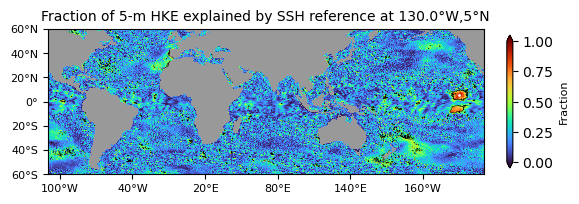

In [5]:
lon_tar =360*(lon_tar<0)+lon_tar
dis = (lon_tar-ref_lon)**2. + (lat_tar-ref_lat)**2.
idx = np.nonzero(dis ==dis.min())


plt.figure(dpi=100)
degree_sign= u'\N{DEGREE SIGN}'
current_cmap = plt.get_cmap('turbo')
current_cmap.set_bad(color='0.6')
cs = plt.pcolormesh(np.arange(0,359.8,0.1),np.arange(-60.,60.1,0.1),frac_re,shading = 'nearest',\
              vmin=0,vmax=1.,cmap=current_cmap)
plt.contour(np.arange(0,359.8,0.1),np.arange(-60.,60.1,0.1),frac_re,[errbar**2.],colors= 'k',linewidths = 0.5)

plt.axis('scaled')
cb = plt.colorbar(cs,extend='both',fraction = 0.013)
cb.set_label('Fraction',fontsize = 8)

#plt.xticks([np.arange(0,359.8,0.1),150,180,210,240,270,300,330],['120'+degree_sign+'E', '150'+degree_sign+'E','180'+degree_sign, '150'+degree_sign+'W','120'+degree_sign+'W','90'+degree_sign+'W','60'+degree_sign+'W','30'+degree_sign+'W'],fontsize = 8)
plt.xticks([np.arange(0,359.8,0.1)[98],\
            np.arange(0,359.8,0.1)[98+600],\
            np.arange(0,359.8,0.1)[98+2*600],\
            np.arange(0,359.8,0.1)[98+3*600],\
           np.arange(0,359.8,0.1)[98+4*600],\
           np.arange(0,359.8,0.1)[98+5*600]],\
           ['100'+degree_sign+'W',\
            '40'+degree_sign+'W',\
           '20'+degree_sign+'E',\
           '80'+degree_sign+'E',\
           '140'+degree_sign+'E',\
           '160'+degree_sign+'W'],fontsize = 8)


plt.yticks([-60,-40,-20,0,20,40,60],['60'+degree_sign+'S','40'+degree_sign+'S','20'+degree_sign+'S','0'+degree_sign, '20'+degree_sign+'N', '40'+degree_sign+'N', '60'+degree_sign+'N'],fontsize = 8)
plt.title('Fraction of 5-m HKE explained by SSH reference at '+\
          str(round(360-x0,1))+degree_sign+'W,'+str(int(y0))+degree_sign+'N',size =10.)
plt.plot(np.arange(0,359.8,0.1)[int(idx[1])],\
         np.arange(-60.,60.1,0.1)[int(idx[0])], marker='o',color='white',markersize = 1);

#plt.savefig('/vortexfs1/scratch/wwu/rossby_wave_python_code/figures/EKE_frac.png',dpi = 300,bbox_inches='tight', pad_inches=0)

plt.show()